# Testing a variety of SKLearn Architectures on processed MRI data

## Data Use Agreements
The data used for this project were provided in part by OASIS and ADNI.

OASIS-3: Principal Investigators: T. Benzinger, D. Marcus, J. Morris; NIH P50 AG00561, P30 NS09857781, P01 AG026276, P01 AG003991, R01 AG043434, UL1 TR000448, R01 EB009352. AV-45 doses were provided by Avid Radiopharmaceuticals, a wholly owned subsidiary of Eli Lilly.

Data collection for this project was done through the Alzheimer's Disease Neuroimaging Initiative (ADNI) (National Institutes of Health Grant U01 AG024904) and DOD ADNI (Department of Defense award number W81XWH-12-2-0012). ADNI is funded by the National Institute on Aging, the National Institute of Biomedical Imaging and Bioengineering, and through generous contributions from the following: AbbVie, Alzheimer’s Association; Alzheimer’s Drug Discovery Foundation; Araclon Biotech; BioClinica, Inc.; Biogen; Bristol-Myers Squibb Company; CereSpir, Inc.; Cogstate; Eisai Inc.; Elan Pharmaceuticals, Inc.; Eli Lilly and Company; EuroImmun; F. Hoffmann-La Roche Ltd and its affiliated company Genentech, Inc.; Fujirebio; GE Healthcare; IXICO Ltd.; Janssen Alzheimer Immunotherapy Research & Development, LLC.; Johnson & Johnson Pharmaceutical Research & Development LLC.; Lumosity; Lundbeck; Merck & Co., Inc.; Meso Scale Diagnostics, LLC.; NeuroRx Research; Neurotrack Technologies; Novartis Pharmaceuticals Corporation; Pfizer Inc.; Piramal Imaging; Servier; Takeda Pharmaceutical Company; and Transition Therapeutics. The Canadian Institutes of Health Research is providing funds to support ADNI clinical sites in Canada. Private sector contributions are facilitated by the Foundation for the National Institutes of Health (www.fnih.org). The grantee organization is the Northern California Institute for Research and Education, and the study is coordinated by the Alzheimer’s Therapeutic Research Institute at the University of Southern California. ADNI data are disseminated by the Laboratory for Neuro Imaging at the University of Southern California.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set()

from tqdm.notebook import tqdm
np.set_printoptions(linewidth=200, suppress=True, formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [2]:
df = pd.read_csv('../Data/OASIS/csv_files/oasis_3.csv')
print(df.shape)

(2168, 22)


In [3]:
df.head()

,Subject,MR ID,id,Age,M/F,dx1,mmse,cdr,apoe,TOTAL_HIPPOCAMPUS_VOLUME,...,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
0,OAS30001,OAS30001_MR_d3132,OAS30001_Freesurfer53_d3132,73.0,F,Cognitively normal,30.0,0.0,23.0,6861.9,...,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
1,OAS30001,OAS30001_MR_d0129,OAS30001_Freesurfer53_d0129,65.0,F,Cognitively normal,30.0,0.0,23.0,7678.9,...,187528.786036,379446.180091,50687.0,517683.180091,8.105851e+05,184600.488060,182662.445419,367262.933479,70168.1,69483.8
2,OAS30001,OAS30001_MR_d2430,OAS30001_Freesurfer53_d2430,71.0,F,Cognitively normal,30.0,0.0,23.0,7105.9,...,178872.680224,357784.489639,49058.0,487405.489639,7.779313e+05,175955.968883,178172.812666,354128.781549,67905.7,68000.2
3,OAS30001,OAS30001_MR_d0757,OAS30001_Freesurfer53_d0757,67.0,F,Cognitively normal,29.0,0.0,23.0,7648.2,...,177566.874682,362040.150904,50071.0,500699.150904,7.993419e+05,185224.779932,188151.990316,373376.770247,69142.3,68558.8
4,OAS30002,OAS30002_MR_d2345,OAS30002_Freesurfer53_d2345,73.0,M,Cognitively normal,29.0,0.0,34.0,7833.2,...,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3


## Data Preprocessing

In [4]:
df = df.dropna(axis=1, how='all') # Drop any empty columns
df = df.dropna(axis=0, how='any') # Drop any rows with empty values 
df = df.drop_duplicates(subset='Subject', keep='first') # Keep only the first visit; this is possible because
                                                        # df is sorted by age
df = df.rename(columns={'id':'Freesurfer ID', 'dx1':'Diagnosis', 
                        'TOTAL_HIPPOCAMPUS_VOLUME':'TotalHippocampusVol'}) # Rename columns
df = df.reset_index(drop=True) # Reset the index

In [5]:
df = df.set_index('Subject')
df.loc[df['cdr'] < 0.5, 'Diagnosis'] = 'control'
df.loc[~(df['cdr'] < 0.5), 'Diagnosis'] = 'dementia'
df.loc[df['Diagnosis'] == 'control', 'Diagnosis'] = 0
df.loc[df['Diagnosis'] == 'dementia', 'Diagnosis'] = 1
df['M/F'].replace(['M','F'], [0,1], inplace=True)
print(df.shape)

(1022, 21)


In [6]:
df = df.drop(['MR ID', 'Freesurfer ID', 'cdr'], axis=1) # Drop categorical and redundant columns

In [7]:
df.head()

,Age,M/F,Diagnosis,mmse,apoe,TotalHippocampusVol,IntraCranialVol,lhCortexVol,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
Subject,,,,,,,,,,,,,,,,,,
OAS30001,73.0,1,0,30.0,23.0,6861.9,1.186091e+06,181943.698754,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
OAS30002,73.0,0,0,29.0,34.0,7833.2,1.714636e+06,227101.503019,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3
OAS30003,66.0,1,0,29.0,33.0,7983.5,1.405092e+06,204825.718573,209641.219733,414466.938306,59379.0,557900.938306,9.299305e+05,213905.159729,222232.368895,436137.528624,76695.5,78697.9
OAS30004,61.0,1,0,30.0,23.0,8525.1,1.443177e+06,213861.671106,206884.661369,420746.332475,53910.0,566477.332475,9.709780e+05,242595.702097,233016.992108,475612.694206,87710.1,84634.9
OAS30005,54.0,1,0,30.0,33.0,9298.2,1.554566e+06,225743.655875,224311.450543,450055.106418,63545.0,611117.106418,9.867349e+05,229534.963360,230927.823126,460462.786487,82224.0,81421.3


<AxesSubplot:title={'center':'Count of diagnosis'}, xlabel='Diagnosis', ylabel='Number of subjects'>

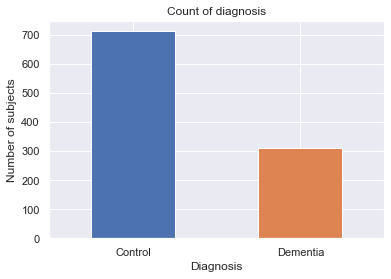

In [8]:
# Gender  and  Group ( Femal=0, Male=1)
data = df['Diagnosis'].value_counts()
data.index = ['Control', 'Dementia']
data.plot(kind='bar', rot=0, title='Count of diagnosis', color=['C0', 'C1'],
         xlabel='Diagnosis', ylabel='Number of subjects')

## Splitting into train, test, and validation sets
Since we will be using sklearn's cross_val_score for cross validation, we will only split the dataset into a validation set and a 'use' set. The validation set will not be seen in training and will only be used for evaluation. The 'use' set will be split into a training and test set by the cross_val_score function from sklearn to perform cross validation on.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

In [10]:
X = df.drop(['Diagnosis'], axis=1)
y = df['Diagnosis'].astype('int')

In [11]:
X_use, X_val, y_use, y_val = train_test_split(X, y, test_size=0.25, random_state=0)
print(X_use.shape, X_val.shape, y_use.shape, y_val.shape)

(766, 17) (256, 17) (766,) (256,)


## Apply scaling and transformations
Since we're not sure if the dataset is normally distributed, we will be using the MinMaxScaler from sklearn. We will also apply a separate PCA transformation and test each architecture on both the original and PCA-transformed datasets

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()
scaler.fit(X_use)
X_use = scaler.transform(X_use)
X_val = scaler.transform(X_val)

In [14]:
pca = PCA(n_components=10)  # we use 10 because it captures 99.7% of the variance
pca.fit(X_use)
print('Explained variance:', np.cumsum(pca.explained_variance_ratio_))
X_use_pca = pca.transform(X_use)
X_val_pca = pca.transform(X_val)

Explained variance: [0.555 0.761 0.824 0.878 0.926 0.955 0.973 0.984 0.991 0.997]


# Machine Learning Architectures
We will test the following architectures, picking the best parameters via cross-validation using sklearn's built in module. In all cases, we will be using 10 fold classification, since that was the most common one used in many similar research according to the Tanveer paper.
* [Support Vector Machines](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
* [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* [k-Nearest Neighbours](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
* [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
* [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [AdaBoost Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

Architectures were picked using the list of the most popular classification methods, linked here: https://www.educative.io/blog/scikit-learn-cheat-sheet-classification-regression-methods

## Setup

In [15]:
# Imports
from sklearn.metrics import accuracy_score,  plot_confusion_matrix
from sklearn.metrics import recall_score, precision_score, plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve, auc, roc_curve, roc_auc_score
from tqdm.notebook import tqdm

In [16]:
# Set the number of folds
kfolds = 10
results = []

## Support Vector Machines
We will be testing a variety of parameters as well as kernels.
* C - this is the regularization parameters, used to define the SVM's "softness"
* kernel - this defines the kernel that will be used in the SVM
* gamma - this is the kernel coefficient, applicable for various kernels

Since individual SVMs take a long time to train, we will be used the BaggingClassifier wrapper to allow multiprocessing. The difference in results should be minimal.

In [17]:
# Import SVM classifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

### No PCA

In [18]:
scores = {}  # this dictionary will store scores in the form of {(*parameters):score}

for kernel in tqdm(['rbf', 'linear', 'poly', 'sigmoid'], desc=f'SVM'):
    for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: 
        for gamma in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
            # Define the model
            svc = BaggingClassifier(SVC(C=C, kernel=kernel, gamma=gamma), max_samples=0.1, n_jobs=-1)
            
            # Get a list of scores using CV
            cv_scores = cross_val_score(svc, X_use, y_use, cv=kfolds, scoring='accuracy')
            
            # Get a final score with the mean of the cv scores
            score = np.mean(cv_scores)
            
            scores[(kernel, C, gamma)] = score


scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
print('%-30s %-10.5s %-7s' % ('Parameters', 'Acc', '|'), end='')
print('%-30s %-10.5s' % ('Parameters', 'Acc'))
print('-'*86)
for i, key in enumerate(scores):
    if i & 1:
        print('%-30s %-10.5s' % (key, scores[key]))
    else:
        print('%-30s %-10.5s %-7s' % (key, scores[key], '|'), end='')

SVM:   0%|          | 0/4 [00:00<?, ?it/s]

Parameters                     Acc        |      Parameters                     Acc       
--------------------------------------------------------------------------------------
('rbf', 1000, 0.1)             0.860      |      ('poly', 10, 1)                0.858     
('linear', 100, 100)           0.855      |      ('linear', 100, 1000)          0.855     
('linear', 1000, 0.1)          0.853      |      ('linear', 100, 0.1)           0.853     
('linear', 10, 0.01)           0.852      |      ('rbf', 1000, 0.01)            0.849     
('linear', 1000, 0.01)         0.848      |      ('poly', 1, 1)                 0.848     
('linear', 100, 0.01)          0.847      |      ('linear', 100, 1)             0.847     
('linear', 1000, 0.001)        0.847      |      ('linear', 100, 10)            0.847     
('linear', 1000, 10)           0.847      |      ('linear', 1000, 1000)         0.845     
('linear', 1000, 1)            0.844      |      ('linear', 1000, 100)          0.844     
('p

In [19]:
kernel, C, gamma = max(scores, key= lambda x: scores[x])
print('The best parameters for the non-pca SVC are:')
print(f'Kernel = {kernel} | C = {C} | Gamma = {gamma}')

final_svc = SVC(kernel=kernel, C=C, gamma=gamma)
final_svc.fit(X_use, y_use)

score = final_svc.score(X_val, y_val)
predictions = final_svc.predict(X_val)
print(f'The test achieved an accuracy of {score}')

recall = recall_score(y_val, predictions, pos_label=1)
precision = precision_score(y_val, predictions, pos_label=1)
print(f'The test achieved a Recall of {recall} and Precision of {precision}')

auc = roc_auc_score(y_val, predictions)
print(f'The test has an AUC of {auc}')

The best parameters for the non-pca SVC are:
Kernel = rbf | C = 1000 | Gamma = 0.1
The test achieved an accuracy of 0.85546875
The test achieved a Recall of 0.7323943661971831 and Precision of 0.7428571428571429
The test has an AUC of 0.8175485344499429


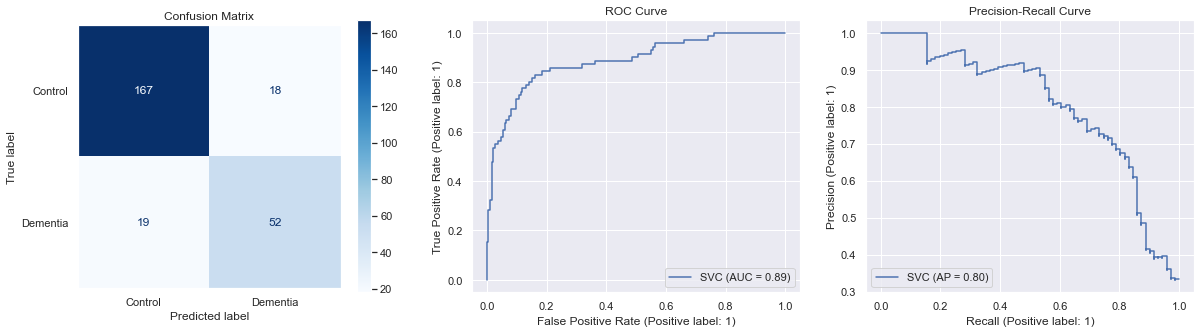

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plot_confusion_matrix(final_svc, X_val, y_val, display_labels=['Control', 'Dementia'], cmap='Blues', ax=ax[0])
ax[0].grid(False)
ax[0].set_title('Confusion Matrix')
plot_roc_curve(final_svc, X_val, y_val, ax=ax[1])
ax[1].set_title('ROC Curve')
plot_precision_recall_curve(final_svc, X_val, y_val, ax=ax[2])
ax[2].set_title('Precision-Recall Curve')

results.append(['SVC', score, recall, precision, auc])

### PCA

In [21]:
scores = {}  # this dictionary will store scores in the form of {(*parameters):score}

for kernel in tqdm(['rbf', 'linear', 'poly', 'sigmoid'], desc=f'SVM'):
    for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: 
        for gamma in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
            # Define the model
            svc = BaggingClassifier(SVC(C=C, kernel=kernel, gamma=gamma), max_samples=0.1, n_jobs=-1)
            
            # Get a list of scores using CV
            cv_scores = cross_val_score(svc, X_use_pca, y_use, cv=kfolds, scoring='accuracy')
            
            # Get a final score with the mean of the cv scores
            score = np.mean(cv_scores)
            
            scores[(kernel, C, gamma)] = score


scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
print('%-30s %-10.5s %-7s' % ('Parameters', 'Acc', '|'), end='')
print('%-30s %-10.5s' % ('Parameters', 'Acc'))
print('-'*86)
for i, key in enumerate(scores):
    if i & 1:
        print('%-30s %-10.5s' % (key, scores[key]))
    else:
        print('%-30s %-10.5s %-7s' % (key, scores[key], '|'), end='')

SVM:   0%|          | 0/4 [00:00<?, ?it/s]

Parameters                     Acc        |      Parameters                     Acc       
--------------------------------------------------------------------------------------
('linear', 1000, 1)            0.860      |      ('linear', 1000, 0.01)         0.857     
('linear', 1000, 1000)         0.857      |      ('rbf', 1000, 0.1)             0.857     
('linear', 100, 10)            0.856      |      ('linear', 100, 0.001)         0.855     
('linear', 1000, 0.001)        0.853      |      ('linear', 100, 100)           0.852     
('linear', 100, 1)             0.852      |      ('linear', 1000, 0.1)          0.852     
('linear', 1000, 10)           0.849      |      ('linear', 100, 0.01)          0.849     
('linear', 100, 0.1)           0.849      |      ('linear', 1000, 100)          0.849     
('rbf', 1000, 0.01)            0.848      |      ('sigmoid', 1000, 0.1)         0.848     
('linear', 100, 1000)          0.847      |      ('linear', 10, 0.01)           0.845     
('s

In [22]:
kernel, C, gamma = max(scores, key= lambda x: scores[x])
print('The best parameters for the non-pca SVC are:')
print(f'Kernel = {kernel} | C = {C} | Gamma = {gamma}')

final_svc = SVC(kernel=kernel, C=C, gamma=gamma)
final_svc.fit(X_use_pca, y_use)

score = final_svc.score(X_val_pca, y_val)
predictions = final_svc.predict(X_val_pca)
print(f'The test achieved an accuracy of {score}')

recall = recall_score(y_val, predictions, pos_label=1)
precision = precision_score(y_val, predictions, pos_label=1)
print(f'The test achieved a Recall of {recall} and Precision of {precision}')

auc = roc_auc_score(y_val, predictions)
print(f'The test has an AUC of {auc}')

The best parameters for the non-pca SVC are:
Kernel = linear | C = 1000 | Gamma = 1
The test achieved an accuracy of 0.8671875
The test achieved a Recall of 0.704225352112676 and Precision of 0.7936507936507936
The test has an AUC of 0.8169775409212029


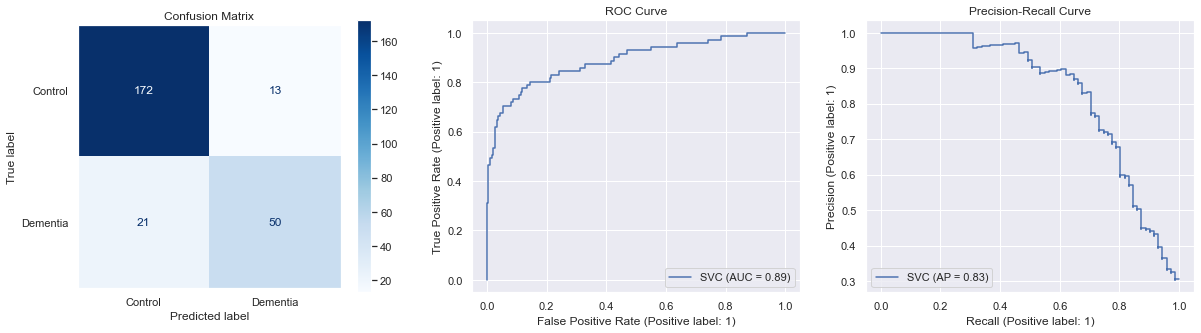

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plot_confusion_matrix(final_svc, X_val_pca, y_val, display_labels=['Control', 'Dementia'], cmap='Blues', ax=ax[0])
ax[0].grid(False)
ax[0].set_title('Confusion Matrix')
plot_roc_curve(final_svc, X_val_pca, y_val, ax=ax[1])
ax[1].set_title('ROC Curve')
plot_precision_recall_curve(final_svc, X_val_pca, y_val, ax=ax[2])
ax[2].set_title('Precision-Recall Curve')

results.append(['SVC w/ PCA', score, recall, precision, auc])

## Gaussian Naive Bayes
This doesn't really have any parameters, so we'll do a straightfoward fit-then-predict.

In [24]:
from sklearn.naive_bayes import GaussianNB

### No PCA

In [25]:
gnb = GaussianNB()
gnb.fit(X_use, y_use)

score = gnb.score(X_val, y_val)
predictions = gnb.predict(X_val)
print(f'The test achieved an accuracy of {score}')

recall = recall_score(y_val, predictions, pos_label=1)
precision = precision_score(y_val, predictions, pos_label=1)
print(f'The test achieved a Recall of {recall} and Precision of {precision}')

auc = roc_auc_score(y_val, predictions)
print(f'The test has an AUC of {auc}')

The test achieved an accuracy of 0.78515625
The test achieved a Recall of 0.6901408450704225 and Precision of 0.5975609756097561
The test has an AUC of 0.7558812333460221


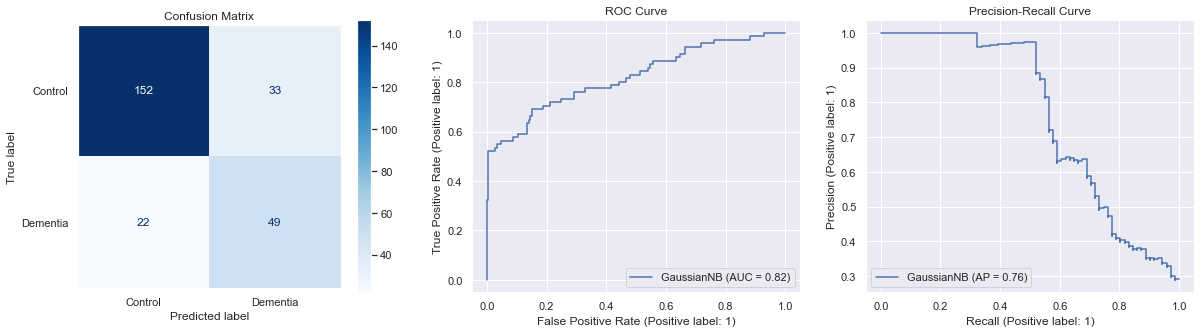

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plot_confusion_matrix(gnb, X_val, y_val, display_labels=['Control', 'Dementia'], cmap='Blues', ax=ax[0])
ax[0].grid(False)
ax[0].set_title('Confusion Matrix')
plot_roc_curve(gnb, X_val, y_val, ax=ax[1])
ax[1].set_title('ROC Curve')
plot_precision_recall_curve(gnb, X_val, y_val, ax=ax[2])
ax[2].set_title('Precision-Recall Curve')

results.append(['Gaussian NB', score, recall, precision, auc])

### PCA

In [27]:
gnb = GaussianNB()
gnb.fit(X_use_pca, y_use)

score = gnb.score(X_val_pca, y_val)
predictions = gnb.predict(X_val_pca)
print(f'The test achieved an accuracy of {score}')

recall = recall_score(y_val, predictions, pos_label=1)
precision = precision_score(y_val, predictions, pos_label=1)
print(f'The test achieved a Recall of {recall} and Precision of {precision}')

auc = roc_auc_score(y_val, predictions)
print(f'The test has an AUC of {auc}')

The test achieved an accuracy of 0.8046875
The test achieved a Recall of 0.5070422535211268 and Precision of 0.7058823529411765
The test has an AUC of 0.7129805862200228


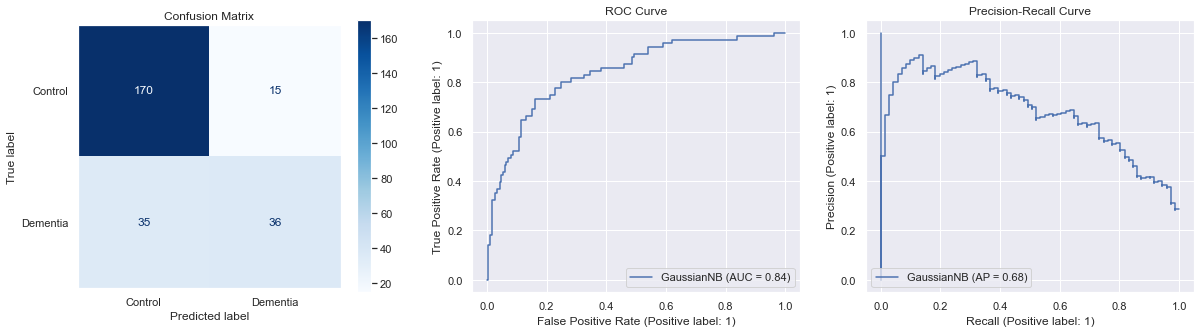

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plot_confusion_matrix(gnb, X_val_pca, y_val, display_labels=['Control', 'Dementia'], cmap='Blues', ax=ax[0])
ax[0].grid(False)
ax[0].set_title('Confusion Matrix')
plot_roc_curve(gnb, X_val_pca, y_val, ax=ax[1])
ax[1].set_title('ROC Curve')
plot_precision_recall_curve(gnb, X_val_pca, y_val, ax=ax[2])
ax[2].set_title('Precision-Recall Curve')

results.append(['Gaussian NB w/ PCA', score, recall, precision, auc])

## Logistic Regression
The parameter C is the inverse of regularization strength

In [29]:
from sklearn.linear_model import LogisticRegression

### No PCA

In [30]:
scores = {}  # this dictionary will store scores in the form of {(*parameters):score}

for C in tqdm([0.001, 0.01, 0.1, 1, 10, 100, 1000], desc='Logistic Regression'): 
    # Define the model
    model = LogisticRegression(C=C, max_iter=1000)

    # Get a list of scores using CV
    cv_scores = cross_val_score(model, X_use, y_use, cv=kfolds, scoring='accuracy')

    # Get a final score with the mean of the cv scores
    score = np.mean(cv_scores)

    scores[(C)] = score


scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
print('%-30s %-10.5s %-7s' % ('Parameters', 'Acc', '|'), end='')
print('%-30s %-10.5s' % ('Parameters', 'Acc'))
print('-'*86)
for i, key in enumerate(scores):
    if i & 1:
        print('%-30s %-10.5s' % (key, scores[key]))
    else:
        print('%-30s %-10.5s %-7s' % (key, scores[key], '|'), end='')

Logistic Regression:   0%|          | 0/7 [00:00<?, ?it/s]

Parameters                     Acc        |      Parameters                     Acc       
--------------------------------------------------------------------------------------
100                            0.860      |      10                             0.860     
1000                           0.860      |      1                              0.835     
0.1                            0.766      |      0.001                          0.687     
0.01                           0.687      |      

In [31]:
C = max(scores, key= lambda x: scores[x])
print('The best parameters for the non-pca Logistic Regression are:')
print(f'C = {C}')

final = LogisticRegression(C=C, max_iter=1000)
final.fit(X_use, y_use)

score = final.score(X_val, y_val)
predictions = final.predict(X_val)
print(f'The test achieved an accuracy of {score}')

recall = recall_score(y_val, predictions, pos_label=1)
precision = precision_score(y_val, predictions, pos_label=1)
print(f'The test achieved a Recall of {recall} and Precision of {precision}')

auc = roc_auc_score(y_val, predictions)
print(f'The test has an AUC of {auc}')

The best parameters for the non-pca Logistic Regression are:
C = 100
The test achieved an accuracy of 0.84765625
The test achieved a Recall of 0.6901408450704225 and Precision of 0.7424242424242424
The test has an AUC of 0.7991244765892653


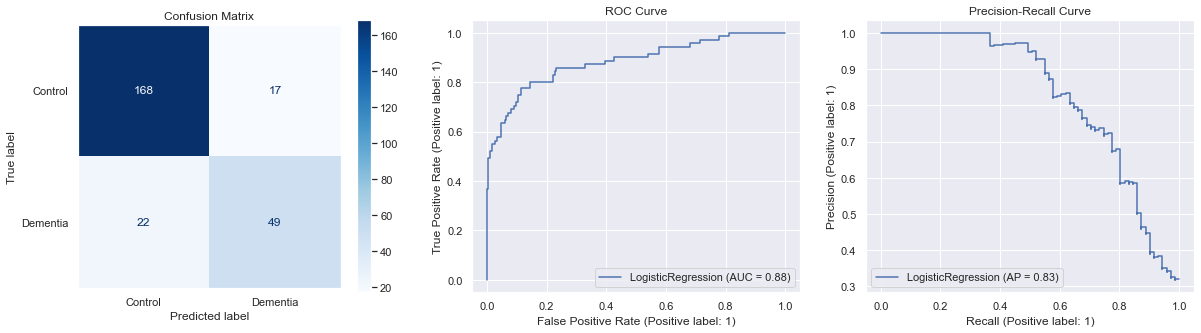

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plot_confusion_matrix(final, X_val, y_val, display_labels=['Control', 'Dementia'], cmap='Blues', ax=ax[0])
ax[0].grid(False)
ax[0].set_title('Confusion Matrix')
plot_roc_curve(final, X_val, y_val, ax=ax[1])
ax[1].set_title('ROC Curve')
plot_precision_recall_curve(final, X_val, y_val, ax=ax[2])
ax[2].set_title('Precision-Recall Curve')

results.append(['Logistic Regression', score, recall, precision, auc])

### PCA

In [33]:
scores = {}  # this dictionary will store scores in the form of {(*parameters):score}

for C in tqdm([0.001, 0.01, 0.1, 1, 10, 100, 1000], desc='Logistic Regression'): 
    # Define the model
    model = LogisticRegression(C=C, max_iter=1000)

    # Get a list of scores using CV
    cv_scores = cross_val_score(model, X_use_pca, y_use, cv=kfolds, scoring='accuracy')

    # Get a final score with the mean of the cv scores
    score = np.mean(cv_scores)

    scores[(C)] = score


scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
print('%-30s %-10.5s %-7s' % ('Parameters', 'Acc', '|'), end='')
print('%-30s %-10.5s' % ('Parameters', 'Acc'))
print('-'*86)
for i, key in enumerate(scores):
    if i & 1:
        print('%-30s %-10.5s' % (key, scores[key]))
    else:
        print('%-30s %-10.5s %-7s' % (key, scores[key], '|'), end='')

Logistic Regression:   0%|          | 0/7 [00:00<?, ?it/s]

Parameters                     Acc        |      Parameters                     Acc       
--------------------------------------------------------------------------------------
100                            0.861      |      1000                           0.860     
10                             0.857      |      1                              0.835     
0.1                            0.766      |      0.001                          0.687     
0.01                           0.687      |      

In [34]:
C = max(scores, key= lambda x: scores[x])
print('The best parameters for the non-pca Logistic Regression are:')
print(f'C = {C}')

final = LogisticRegression(C=C, max_iter=1000)
final.fit(X_use_pca, y_use)

score = final.score(X_val_pca, y_val)
predictions = final.predict(X_val_pca)
print(f'The test achieved an accuracy of {score}')

recall = recall_score(y_val, predictions, pos_label=1)
precision = precision_score(y_val, predictions, pos_label=1)
print(f'The test achieved a Recall of {recall} and Precision of {precision}')

auc = roc_auc_score(y_val, predictions)
print(f'The test has an AUC of {auc}')

The best parameters for the non-pca Logistic Regression are:
C = 100
The test achieved an accuracy of 0.859375
The test achieved a Recall of 0.704225352112676 and Precision of 0.7692307692307693
The test has an AUC of 0.8115721355157974


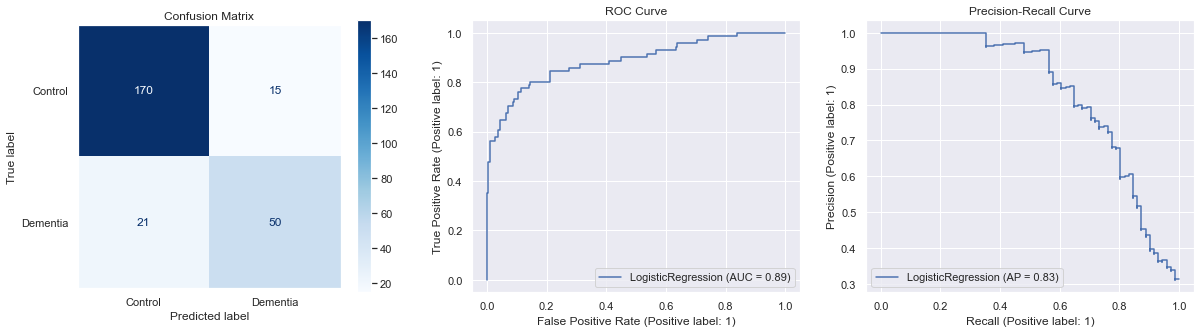

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
cm = plot_confusion_matrix(final, X_val_pca, y_val, display_labels=['Control', 'Dementia'], cmap='Blues', ax=ax[0])
ax[0].grid(False)
ax[0].set_title('Confusion Matrix')
roc = plot_roc_curve(final, X_val_pca, y_val, ax=ax[1])
ax[1].set_title('ROC Curve')
prc = plot_precision_recall_curve(final, X_val_pca, y_val, ax=ax[2])
ax[2].set_title('Precision-Recall Curve')

results.append(['Logistic Regression w/ PCA', score, recall, precision, auc])

## k-Nearest Neighbors
* n_neighbors - the number of neighbors
* p - power parameter for the Minkowski metric

In [36]:
from sklearn.neighbors import KNeighborsClassifier

### No PCA

In [37]:
scores = {}  # this dictionary will store scores in the form of {(*parameters):score}

for n in tqdm([5, 10, 15, 20, 25, 30], desc='k-Nearest Neighbors'):
    for p in [1, 2, 3, 4, 5]:
        # Define the model
        model = KNeighborsClassifier(n_neighbors=n, p=p)

        # Get a list of scores using CV
        cv_scores = cross_val_score(model, X_use, y_use, cv=kfolds, scoring='accuracy')

        # Get a final score with the mean of the cv scores
        score = np.mean(cv_scores)

        scores[(n, p)] = score


scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
print('%-30s %-10.5s %-7s' % ('Parameters', 'Acc', '|'), end='')
print('%-30s %-10.5s' % ('Parameters', 'Acc'))
print('-'*86)
for i, key in enumerate(scores):
    if i & 1:
        print('%-30s %-10.5s' % (key, scores[key]))
    else:
        print('%-30s %-10.5s %-7s' % (key, scores[key], '|'), end='')

k-Nearest Neighbors:   0%|          | 0/6 [00:00<?, ?it/s]

Parameters                     Acc        |      Parameters                     Acc       
--------------------------------------------------------------------------------------
(25, 4)                        0.804      |      (20, 4)                        0.802     
(25, 5)                        0.802      |      (10, 2)                        0.798     
(15, 3)                        0.798      |      (10, 3)                        0.798     
(5, 2)                         0.798      |      (25, 3)                        0.798     
(10, 4)                        0.797      |      (15, 4)                        0.797     
(5, 1)                         0.797      |      (5, 5)                         0.797     
(30, 4)                        0.795      |      (10, 5)                        0.795     
(30, 5)                        0.793      |      (15, 5)                        0.793     
(20, 5)                        0.793      |      (5, 3)                         0.793     
(5,

In [38]:
n, p = max(scores, key= lambda x: scores[x])
print('The best parameters for the non-pca Logistic Regression are:')
print(f'n_neighbors = {n} | p = {p}')

final = KNeighborsClassifier(n_neighbors=n, p=p)
final.fit(X_use, y_use)

score = final.score(X_val, y_val)
predictions = final.predict(X_val)
print(f'The test achieved an accuracy of {score}')

recall = recall_score(y_val, predictions, pos_label=1)
precision = precision_score(y_val, predictions, pos_label=1)
print(f'The test achieved a Recall of {recall} and Precision of {precision}')

auc = roc_auc_score(y_val, predictions)
print(f'The test has an AUC of {auc}')

The best parameters for the non-pca Logistic Regression are:
n_neighbors = 25 | p = 4
The test achieved an accuracy of 0.8515625
The test achieved a Recall of 0.49295774647887325 and Precision of 0.9459459459459459
The test has an AUC of 0.7410734678340313


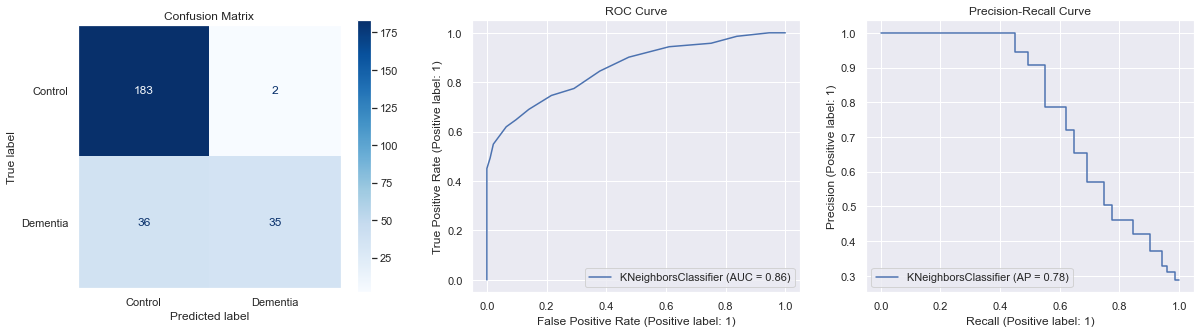

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plot_confusion_matrix(final, X_val, y_val, display_labels=['Control', 'Dementia'], cmap='Blues', ax=ax[0])
ax[0].grid(False)
ax[0].set_title('Confusion Matrix')
plot_roc_curve(final, X_val, y_val, ax=ax[1])
ax[1].set_title('ROC Curve')
plot_precision_recall_curve(final, X_val, y_val, ax=ax[2])
ax[2].set_title('Precision-Recall Curve')

results.append(['k-Nearest Neighbors', score, recall, precision, auc])

### PCA

In [40]:
scores = {}  # this dictionary will store scores in the form of {(*parameters):score}

for n in tqdm([5, 10, 15, 20, 25, 30], desc='k-Nearest Neighbors'):
    for p in [1, 2, 3, 4, 5]:
        # Define the model
        model = KNeighborsClassifier(n_neighbors=n, p=p)

        # Get a list of scores using CV
        cv_scores = cross_val_score(model, X_use_pca, y_use, cv=kfolds, scoring='accuracy')

        # Get a final score with the mean of the cv scores
        score = np.mean(cv_scores)

        scores[(n, p)] = score


scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
print('%-30s %-10.5s %-7s' % ('Parameters', 'Acc', '|'), end='')
print('%-30s %-10.5s' % ('Parameters', 'Acc'))
print('-'*86)
for i, key in enumerate(scores):
    if i & 1:
        print('%-30s %-10.5s' % (key, scores[key]))
    else:
        print('%-30s %-10.5s %-7s' % (key, scores[key], '|'), end='')

k-Nearest Neighbors:   0%|          | 0/6 [00:00<?, ?it/s]

Parameters                     Acc        |      Parameters                     Acc       
--------------------------------------------------------------------------------------
(10, 1)                        0.809      |      (15, 1)                        0.802     
(15, 5)                        0.802      |      (25, 1)                        0.801     
(15, 4)                        0.801      |      (15, 3)                        0.801     
(10, 3)                        0.797      |      (20, 4)                        0.797     
(10, 5)                        0.797      |      (20, 5)                        0.797     
(20, 3)                        0.796      |      (10, 4)                        0.796     
(30, 1)                        0.795      |      (10, 2)                        0.795     
(15, 2)                        0.794      |      (20, 1)                        0.793     
(25, 5)                        0.793      |      (25, 3)                        0.792     
(25

In [41]:
n, p = max(scores, key= lambda x: scores[x])
print('The best parameters for the non-pca Logistic Regression are:')
print(f'n_neighbors = {n} | p = {p}')

final = KNeighborsClassifier(n_neighbors=n, p=p)
final.fit(X_use_pca, y_use)

score = final.score(X_val_pca, y_val)
predictions = final.predict(X_val_pca)
print(f'The test achieved an accuracy of {score}')

recall = recall_score(y_val, predictions, pos_label=1)
precision = precision_score(y_val, predictions, pos_label=1)
print(f'The test achieved a Recall of {recall} and Precision of {precision}')

auc = roc_auc_score(y_val, predictions)
print(f'The test has an AUC of {auc}')

The best parameters for the non-pca Logistic Regression are:
n_neighbors = 10 | p = 1
The test achieved an accuracy of 0.8203125
The test achieved a Recall of 0.43661971830985913 and Precision of 0.8378378378378378
The test has an AUC of 0.7020936429387133


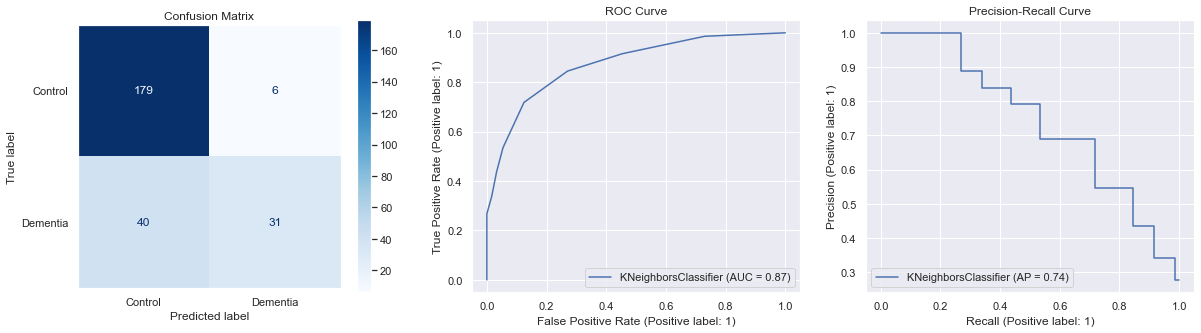

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plot_confusion_matrix(final, X_val_pca, y_val, display_labels=['Control', 'Dementia'], cmap='Blues', ax=ax[0])
ax[0].grid(False)
ax[0].set_title('Confusion Matrix')
plot_roc_curve(final, X_val_pca, y_val, ax=ax[1])
ax[1].set_title('ROC Curve')
plot_precision_recall_curve(final, X_val_pca, y_val, ax=ax[2])
ax[2].set_title('Precision-Recall Curve')

results.append(['k-Nearest Neighbors w/ PCA', score, recall, precision, auc])

## Decision Tree
* Maximum depth - [1, 2, ... n_features]

In [43]:
from sklearn.tree import DecisionTreeClassifier

### No PCA

In [44]:
scores = {}  # this dictionary will store scores in the form of {(*parameters):score}
n_features = X_use.shape[1]
for md in tqdm(range(1, n_features+1), desc='Decision Tree'):
    # Define the model
    model = DecisionTreeClassifier(max_depth=md)

    # Get a list of scores using CV
    cv_scores = cross_val_score(model, X_use, y_use, cv=kfolds, scoring='accuracy')

    # Get a final score with the mean of the cv scores
    score = np.mean(cv_scores)

    scores[(md)] = score


scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
print('%-30s %-10.5s %-7s' % ('Parameters', 'Acc', '|'), end='')
print('%-30s %-10.5s' % ('Parameters', 'Acc'))
print('-'*86)
for i, key in enumerate(scores):
    if i & 1:
        print('%-30s %-10.5s' % (key, scores[key]))
    else:
        print('%-30s %-10.5s %-7s' % (key, scores[key], '|'), end='')

Decision Tree:   0%|          | 0/17 [00:00<?, ?it/s]

Parameters                     Acc        |      Parameters                     Acc       
--------------------------------------------------------------------------------------
3                              0.839      |      1                              0.839     
5                              0.839      |      2                              0.835     
4                              0.832      |      7                              0.832     
6                              0.831      |      8                              0.828     
11                             0.815      |      9                              0.806     
12                             0.802      |      10                             0.800     
16                             0.796      |      14                             0.794     
15                             0.790      |      13                             0.790     
17                             0.789      |      

In [45]:
md = max(scores, key= lambda x: scores[x])
print('The best parameters for the non-pca Logistic Regression are:')
print(f'max_depth = {md}')

final = DecisionTreeClassifier(random_state=0, max_depth=md)
final.fit(X_use, y_use)

score = final.score(X_val, y_val)
predictions = final.predict(X_val)
print(f'The test achieved an accuracy of {score}')

recall = recall_score(y_val, predictions, pos_label=1)
precision = precision_score(y_val, predictions, pos_label=1)
print(f'The test achieved a Recall of {recall} and Precision of {precision}')

auc = roc_auc_score(y_val, predictions)
print(f'The test has an AUC of {auc}')

The best parameters for the non-pca Logistic Regression are:
max_depth = 3
The test achieved an accuracy of 0.84375
The test achieved a Recall of 0.676056338028169 and Precision of 0.7384615384615385
The test has an AUC of 0.7920822230681387


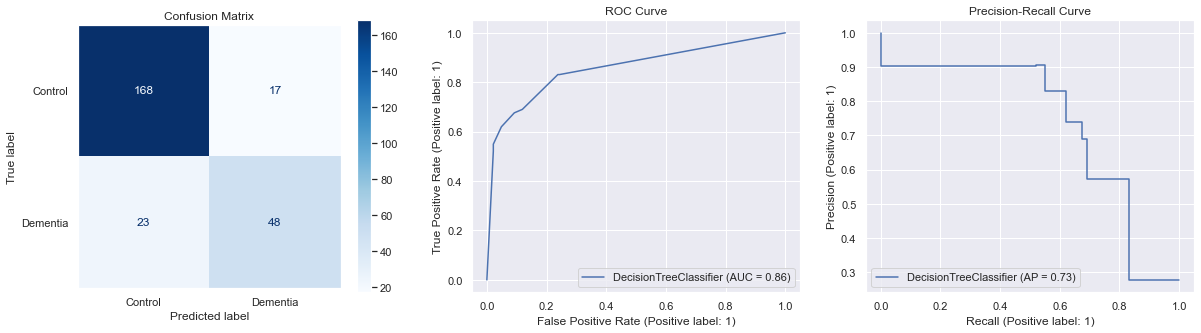

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plot_confusion_matrix(final, X_val, y_val, display_labels=['Control', 'Dementia'], cmap='Blues', ax=ax[0])
ax[0].grid(False)
ax[0].set_title('Confusion Matrix')
plot_roc_curve(final, X_val, y_val, ax=ax[1])
ax[1].set_title('ROC Curve')
plot_precision_recall_curve(final, X_val, y_val, ax=ax[2])
ax[2].set_title('Precision-Recall Curve')

results.append(['Decision Tree', score, recall, precision, auc])

In [47]:
print("Feature importance: ")
np.array([X.columns.values.tolist(), list(final.feature_importances_)]).T

Feature importance: 


array([['Age', '0.0'],
       ['M/F', '0.0'],
       ['mmse', '0.8422950626145622'],
       ['apoe', '0.0'],
       ['TotalHippocampusVol', '0.10178266383973607'],
       ['IntraCranialVol', '0.032330346125843616'],
       ['lhCortexVol', '0.008754701933381348'],
       ['rhCortexVol', '0.014837225486476816'],
       ['CortexVol', '0.0'],
       ['SubCortGrayVol', '0.0'],
       ['TotalGrayVol', '0.0'],
       ['SupraTentorialVol', '0.0'],
       ['lhCorticalWhiteMatterVol', '0.0'],
       ['rhCorticalWhiteMatterVol', '0.0'],
       ['CorticalWhiteMatterVol', '0.0'],
       ['L.SurfArea', '0.0'],
       ['R.SurfArea', '0.0']], dtype='<U24')

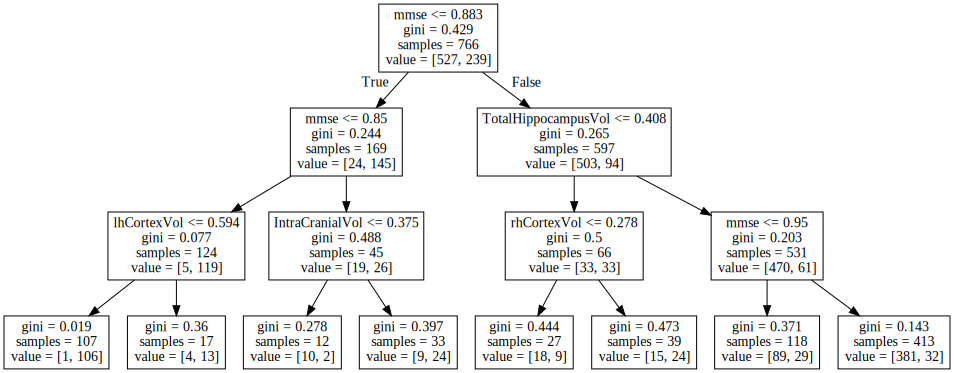

In [48]:
from sklearn.tree import export_graphviz
import graphviz 
dot_data=export_graphviz(final, feature_names=X.columns.values.tolist(),out_file=None)
graph = graphviz.Source(dot_data)  
graph

### PCA

In [49]:
scores = {}  # this dictionary will store scores in the form of {(*parameters):score}
n_features = X_use_pca.shape[1]
for md in tqdm(range(1, n_features+1), desc='Decision Tree'):
    # Define the model
    model = DecisionTreeClassifier(random_state=0, max_depth=md)

    # Get a list of scores using CV
    cv_scores = cross_val_score(model, X_use_pca, y_use, cv=kfolds, scoring='accuracy')

    # Get a final score with the mean of the cv scores
    score = np.mean(cv_scores)

    scores[(md)] = score


scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
print('%-30s %-10.5s %-7s' % ('Parameters', 'Acc', '|'), end='')
print('%-30s %-10.5s' % ('Parameters', 'Acc'))
print('-'*86)
for i, key in enumerate(scores):
    if i & 1:
        print('%-30s %-10.5s' % (key, scores[key]))
    else:
        print('%-30s %-10.5s %-7s' % (key, scores[key], '|'), end='')

Decision Tree:   0%|          | 0/10 [00:00<?, ?it/s]

Parameters                     Acc        |      Parameters                     Acc       
--------------------------------------------------------------------------------------
3                              0.787      |      2                              0.785     
7                              0.779      |      6                              0.779     
4                              0.775      |      5                              0.771     
10                             0.765      |      8                              0.765     
1                              0.765      |      9                              0.762     


In [50]:
md = max(scores, key= lambda x: scores[x])
print('The best parameters for the non-pca Logistic Regression are:')
print(f'max_depth = {md}')

final = DecisionTreeClassifier(max_depth=md)
final.fit(X_use_pca, y_use)

score = final.score(X_val_pca, y_val)
predictions = final.predict(X_val_pca)
print(f'The test achieved an accuracy of {score}')

recall = recall_score(y_val, predictions, pos_label=1)
precision = precision_score(y_val, predictions, pos_label=1)
print(f'The test achieved a Recall of {recall} and Precision of {precision}')

auc = roc_auc_score(y_val, predictions)
print(f'The test has an AUC of {auc}')

The best parameters for the non-pca Logistic Regression are:
max_depth = 3
The test achieved an accuracy of 0.80859375
The test achieved a Recall of 0.4507042253521127 and Precision of 0.7619047619047619
The test has an AUC of 0.6983250856490293


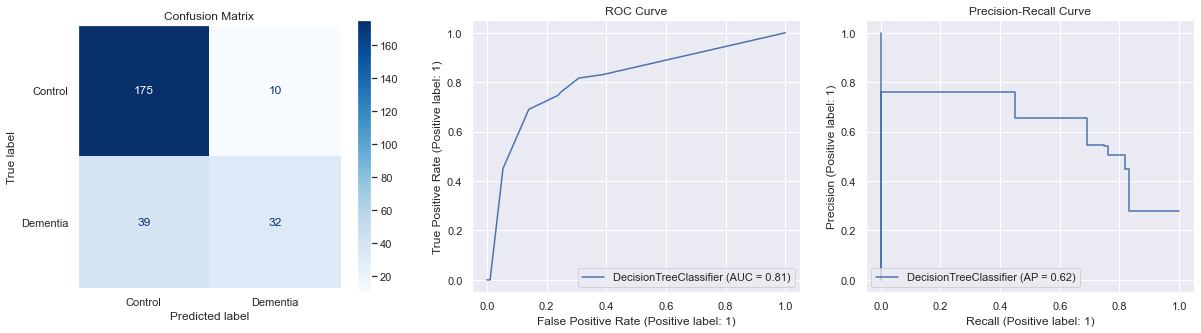

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plot_confusion_matrix(final, X_val_pca, y_val, display_labels=['Control', 'Dementia'], cmap='Blues', ax=ax[0])
ax[0].grid(False)
ax[0].set_title('Confusion Matrix')
plot_roc_curve(final, X_val_pca, y_val, ax=ax[1])
ax[1].set_title('ROC Curve')
plot_precision_recall_curve(final, X_val_pca, y_val, ax=ax[2])
ax[2].set_title('Precision-Recall Curve')

results.append(['Decision Tree w/ PCA', score, recall, precision, auc])

## Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

### No PCA

In [53]:
scores = {}  # this dictionary will store scores in the form of {(*parameters):score}
n_features = X_use.shape[1]
for n in tqdm([2, 4, 6, 8, 10, 30, 50, 70, 100], desc='RF'):
    for f in range(1, n_features+1):
        for md in range(1, n_features+1):
            # Define the model
            model = RandomForestClassifier(n_estimators=n, max_features=f, max_depth=md, n_jobs=-1, random_state=0)

            # Get a list of scores using CV
            cv_scores = cross_val_score(model, X_use, y_use, cv=kfolds, scoring='accuracy')

            # Get a final score with the mean of the cv scores
            score = np.mean(cv_scores)

            scores[(n, f, md)] = score


scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
print('%-30s %-10.5s %-7s' % ('Parameters', 'Acc', '|'), end='')
print('%-30s %-10.5s' % ('Parameters', 'Acc'))
print('-'*86)
for i, key in enumerate(scores):
    if i & 1:
        print('%-30s %-10.5s' % (key, scores[key]))
    else:
        print('%-30s %-10.5s %-7s' % (key, scores[key], '|'), end='')

RF:   0%|          | 0/9 [00:00<?, ?it/s]

Parameters                     Acc        |      Parameters                     Acc       
--------------------------------------------------------------------------------------
(100, 5, 11)                   0.872      |      (30, 8, 12)                    0.872     
(100, 8, 10)                   0.870      |      (70, 5, 6)                     0.870     
(30, 8, 11)                    0.870      |      (50, 3, 7)                     0.870     
(100, 5, 10)                   0.869      |      (50, 8, 9)                     0.869     
(100, 5, 8)                    0.869      |      (30, 8, 15)                    0.869     
(70, 4, 9)                     0.868      |      (70, 3, 7)                     0.868     
(100, 5, 6)                    0.868      |      (50, 8, 10)                    0.868     
(70, 5, 10)                    0.868      |      (100, 5, 13)                   0.868     
(30, 8, 10)                    0.868      |      (100, 2, 15)                   0.868     
(30

In [54]:
n, f, md = max(scores, key= lambda x: scores[x])
print('The best parameters for the non-pca Logistic Regression are:')
print(f'n_estimators = {n} | max_features = {f} | max_depth = {md}')

final = RandomForestClassifier(n_estimators=n, max_features=f, max_depth=md, n_jobs=-1, random_state=0)
final.fit(X_use, y_use)

score = final.score(X_val, y_val)
predictions = final.predict(X_val)
print(f'The test achieved an accuracy of {score}')

recall = recall_score(y_val, predictions, pos_label=1)
precision = precision_score(y_val, predictions, pos_label=1)
print(f'The test achieved a Recall of {recall} and Precision of {precision}')

auc = roc_auc_score(y_val, predictions)
print(f'The test has an AUC of {auc}')

The best parameters for the non-pca Logistic Regression are:
n_estimators = 100 | max_features = 5 | max_depth = 11
The test achieved an accuracy of 0.83984375
The test achieved a Recall of 0.676056338028169 and Precision of 0.7272727272727273
The test has an AUC of 0.7893795203654358


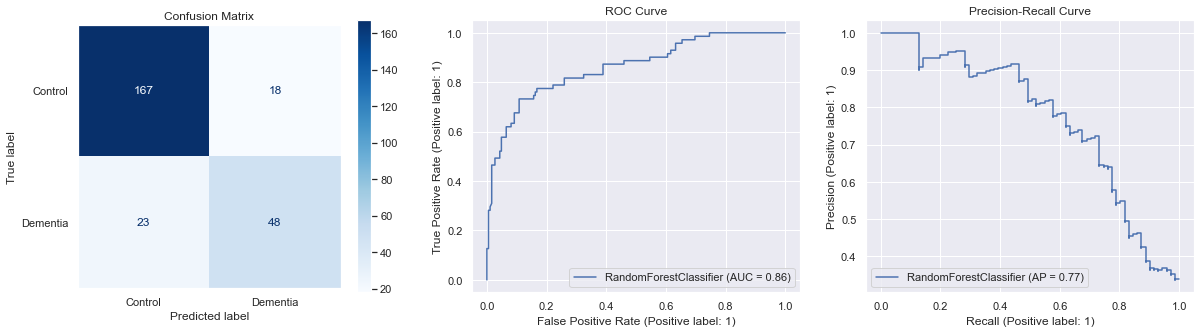

In [55]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plot_confusion_matrix(final, X_val, y_val, display_labels=['Control', 'Dementia'], cmap='Blues', ax=ax[0])
ax[0].grid(False)
ax[0].set_title('Confusion Matrix')
plot_roc_curve(final, X_val, y_val, ax=ax[1])
ax[1].set_title('ROC Curve')
plot_precision_recall_curve(final, X_val, y_val, ax=ax[2])
ax[2].set_title('Precision-Recall Curve')

results.append(['Random Forest', score, recall, precision, auc])

### PCA

In [56]:
scores = {}  # this dictionary will store scores in the form of {(*parameters):score}
n_features = X_use_pca.shape[1]
for n in tqdm([2, 4, 6, 8, 10, 30, 50, 70, 100], desc='RF'):
    for f in range(1, n_features+1):
        for md in range(1, n_features+1):
            # Define the model
            model = RandomForestClassifier(n_estimators=n, max_features=f, max_depth=md, n_jobs=-1, random_state=0)

            # Get a list of scores using CV
            cv_scores = cross_val_score(model, X_use_pca, y_use, cv=kfolds, scoring='accuracy')

            # Get a final score with the mean of the cv scores
            score = np.mean(cv_scores)

            scores[(n, f, md)] = score


scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
print('%-30s %-10.5s %-7s' % ('Parameters', 'Acc', '|'), end='')
print('%-30s %-10.5s' % ('Parameters', 'Acc'))
print('-'*86)
for i, key in enumerate(scores):
    if i & 1:
        print('%-30s %-10.5s' % (key, scores[key]))
    else:
        print('%-30s %-10.5s %-7s' % (key, scores[key], '|'), end='')

RF:   0%|          | 0/9 [00:00<?, ?it/s]

Parameters                     Acc        |      Parameters                     Acc       
--------------------------------------------------------------------------------------
(50, 4, 9)                     0.847      |      (70, 4, 9)                     0.847     
(100, 1, 9)                    0.847      |      (100, 5, 10)                   0.845     
(70, 5, 10)                    0.845      |      (100, 3, 7)                    0.845     
(70, 3, 7)                     0.845      |      (100, 3, 8)                    0.844     
(100, 3, 10)                   0.844      |      (50, 3, 8)                     0.844     
(100, 5, 9)                    0.844      |      (100, 2, 8)                    0.844     
(100, 5, 8)                    0.843      |      (30, 3, 8)                     0.843     
(30, 2, 8)                     0.843      |      (100, 6, 9)                    0.842     
(100, 1, 10)                   0.842      |      (70, 1, 9)                     0.841     
(30

In [57]:
n, f, md = max(scores, key= lambda x: scores[x])
print('The best parameters for the non-pca Logistic Regression are:')
print(f'n_estimators = {n} | max_features = {f} | max_depth = {md}')

final = RandomForestClassifier(n_estimators=n, max_features=f, max_depth=md, n_jobs=-1, random_state=0)
final.fit(X_use_pca, y_use)

score = final.score(X_val_pca, y_val)
predictions = final.predict(X_val_pca)
print(f'The test achieved an accuracy of {score}')

recall = recall_score(y_val, predictions, pos_label=1)
precision = precision_score(y_val, predictions, pos_label=1)
print(f'The test achieved a Recall of {recall} and Precision of {precision}')

auc = roc_auc_score(y_val, predictions)
print(f'The test has an AUC of {auc}')

The best parameters for the non-pca Logistic Regression are:
n_estimators = 50 | max_features = 4 | max_depth = 9
The test achieved an accuracy of 0.86328125
The test achieved a Recall of 0.647887323943662 and Precision of 0.8214285714285714
The test has an AUC of 0.796916634944804


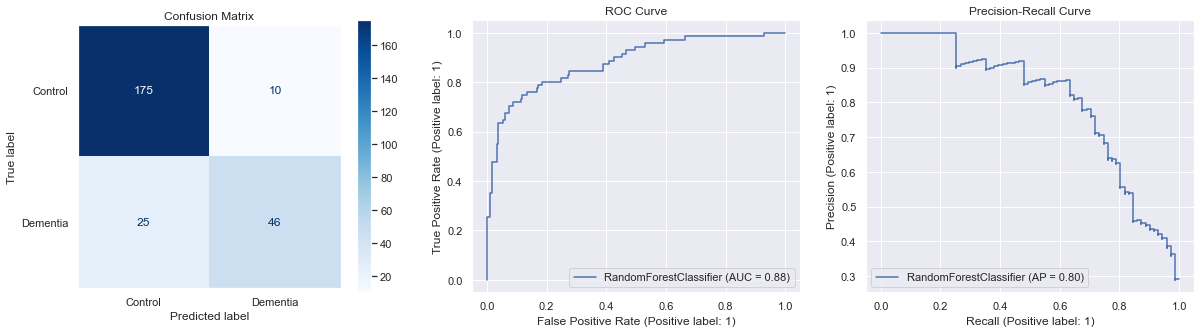

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plot_confusion_matrix(final, X_val_pca, y_val, display_labels=['Control', 'Dementia'], cmap='Blues', ax=ax[0])
ax[0].grid(False)
ax[0].set_title('Confusion Matrix')
plot_roc_curve(final, X_val_pca, y_val, ax=ax[1])
ax[1].set_title('ROC Curve')
plot_precision_recall_curve(final, X_val_pca, y_val, ax=ax[2])
ax[2].set_title('Precision-Recall Curve')

results.append(['Random Forest w/ PCA', score, recall, precision, auc])

## AdaBoost

In [59]:
from sklearn.ensemble import AdaBoostClassifier

### No PCA

In [60]:
scores = {}  # this dictionary will store scores in the form of {(*parameters):score}
n_features = X_use.shape[1]
for n in tqdm([2, 4, 6, 8, 10, 30, 50, 70, 100], desc='AdaBoost'):
    for lr in [0.0001, 0.001, 0.01, 0.1, 1]:
        # Define the model
        model = AdaBoostClassifier(n_estimators=n, learning_rate=lr, random_state=0)

        # Get a list of scores using CV
        cv_scores = cross_val_score(model, X_use, y_use, cv=kfolds, scoring='accuracy')

        # Get a final score with the mean of the cv scores
        score = np.mean(cv_scores)

        scores[(n, lr)] = score


scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
print('%-30s %-10.5s %-7s' % ('Parameters', 'Acc', '|'), end='')
print('%-30s %-10.5s' % ('Parameters', 'Acc'))
print('-'*86)
for i, key in enumerate(scores):
    if i & 1:
        print('%-30s %-10.5s' % (key, scores[key]))
    else:
        print('%-30s %-10.5s %-7s' % (key, scores[key], '|'), end='')

AdaBoost:   0%|          | 0/9 [00:00<?, ?it/s]

Parameters                     Acc        |      Parameters                     Acc       
--------------------------------------------------------------------------------------
(50, 0.1)                      0.856      |      (70, 0.1)                      0.856     
(100, 0.1)                     0.851      |      (30, 0.1)                      0.849     
(2, 0.1)                       0.845      |      (70, 1)                        0.844     
(10, 1)                        0.844      |      (10, 0.1)                      0.843     
(8, 1)                         0.843      |      (4, 1)                         0.842     
(100, 0.01)                    0.839      |      (2, 0.0001)                    0.839     
(2, 0.001)                     0.839      |      (2, 0.01)                      0.839     
(2, 1)                         0.839      |      (4, 0.0001)                    0.839     
(4, 0.001)                     0.839      |      (4, 0.01)                      0.839     
(4,

In [61]:
n, lr = max(scores, key= lambda x: scores[x])
print('The best parameters for the non-pca Logistic Regression are:')
print(f'n_estimators = {n} | learning_rate = {lr}')

final = AdaBoostClassifier(n_estimators=n, learning_rate=lr, random_state=0)
final.fit(X_use, y_use)

score = final.score(X_val, y_val)
predictions = final.predict(X_val)
print(f'The test achieved an accuracy of {score}')

recall = recall_score(y_val, predictions, pos_label=1)
precision = precision_score(y_val, predictions, pos_label=1)
print(f'The test achieved a Recall of {recall} and Precision of {precision}')

auc = roc_auc_score(y_val, predictions)
print(f'The test has an AUC of {auc}')

The best parameters for the non-pca Logistic Regression are:
n_estimators = 50 | learning_rate = 0.1
The test achieved an accuracy of 0.85546875
The test achieved a Recall of 0.6056338028169014 and Precision of 0.8269230769230769
The test has an AUC of 0.7784925770841264


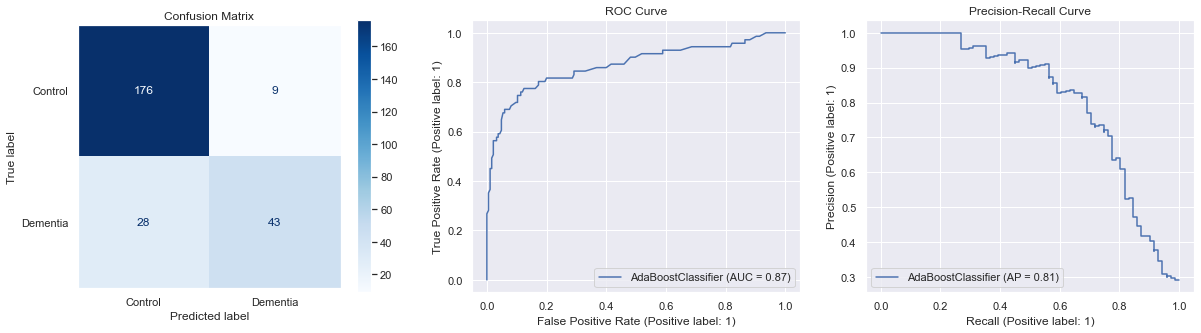

In [62]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plot_confusion_matrix(final, X_val, y_val, display_labels=['Control', 'Dementia'], cmap='Blues', ax=ax[0])
ax[0].grid(False)
ax[0].set_title('Confusion Matrix')
plot_roc_curve(final, X_val, y_val, ax=ax[1])
ax[1].set_title('ROC Curve')
plot_precision_recall_curve(final, X_val, y_val, ax=ax[2])
ax[2].set_title('Precision-Recall Curve')

results.append(['AdaBoost', score, recall, precision, auc])

### PCA

In [63]:
scores = {}  # this dictionary will store scores in the form of {(*parameters):score}
n_features = X_use_pca.shape[1]
for n in tqdm([2, 4, 6, 8, 10, 30, 50, 70, 100], desc='AdaBoost'):
    for lr in [0.0001, 0.001, 0.01, 0.1, 1]:
        # Define the model
        model = AdaBoostClassifier(n_estimators=n, learning_rate=lr, random_state=0)

        # Get a list of scores using CV
        cv_scores = cross_val_score(model, X_use_pca, y_use, cv=kfolds, scoring='accuracy')

        # Get a final score with the mean of the cv scores
        score = np.mean(cv_scores)

        scores[(n, lr)] = score


scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
print('%-30s %-10.5s %-7s' % ('Parameters', 'Acc', '|'), end='')
print('%-30s %-10.5s' % ('Parameters', 'Acc'))
print('-'*86)
for i, key in enumerate(scores):
    if i & 1:
        print('%-30s %-10.5s' % (key, scores[key]))
    else:
        print('%-30s %-10.5s %-7s' % (key, scores[key], '|'), end='')

AdaBoost:   0%|          | 0/9 [00:00<?, ?it/s]

Parameters                     Acc        |      Parameters                     Acc       
--------------------------------------------------------------------------------------
(100, 0.1)                     0.841      |      (70, 0.1)                      0.832     
(50, 1)                        0.831      |      (8, 1)                         0.831     
(70, 1)                        0.829      |      (50, 0.1)                      0.825     
(100, 1)                       0.822      |      (30, 1)                        0.821     
(6, 1)                         0.821      |      (4, 1)                         0.819     
(10, 1)                        0.815      |      (30, 0.1)                      0.814     
(10, 0.1)                      0.785      |      (70, 0.01)                     0.780     
(100, 0.01)                    0.778      |      (4, 0.1)                       0.776     
(50, 0.01)                     0.776      |      (30, 0.01)                     0.775     
(6,

In [64]:
n, lr = max(scores, key= lambda x: scores[x])
print('The best parameters for the non-pca Logistic Regression are:')
print(f'n_estimators = {n} | learning_rate = {lr}')

final = AdaBoostClassifier(n_estimators=n, learning_rate=lr, random_state=0)
final.fit(X_use_pca, y_use)

score = final.score(X_val_pca, y_val)
predictions = final.predict(X_val_pca)
print(f'The test achieved an accuracy of {score}')

recall = recall_score(y_val, predictions, pos_label=1)
precision = precision_score(y_val, predictions, pos_label=1)
print(f'The test achieved a Recall of {recall} and Precision of {precision}')

auc = roc_auc_score(y_val, predictions)
print(f'The test has an AUC of {auc}')

The best parameters for the non-pca Logistic Regression are:
n_estimators = 100 | learning_rate = 0.1
The test achieved an accuracy of 0.86328125
The test achieved a Recall of 0.6338028169014085 and Precision of 0.8333333333333334
The test has an AUC of 0.79257708412638


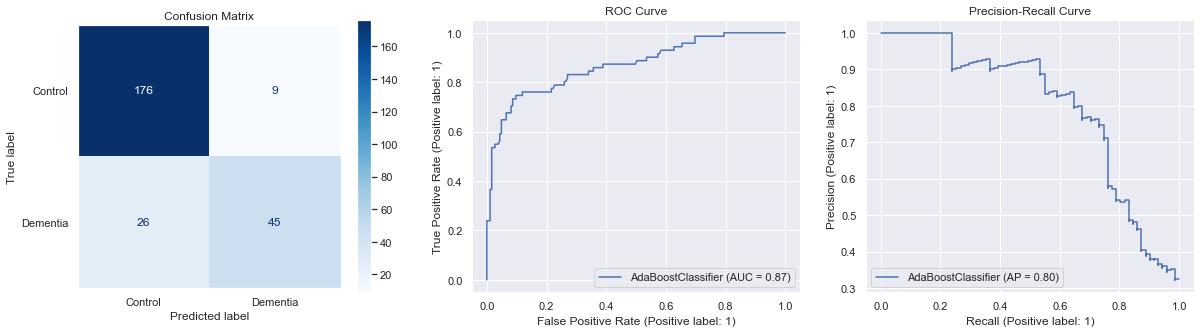

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plot_confusion_matrix(final, X_val_pca, y_val, display_labels=['Control', 'Dementia'], cmap='Blues', ax=ax[0])
ax[0].grid(False)
ax[0].set_title('Confusion Matrix')
plot_roc_curve(final, X_val_pca, y_val, ax=ax[1])
ax[1].set_title('ROC Curve')
plot_precision_recall_curve(final, X_val_pca, y_val, ax=ax[2])
ax[2].set_title('Precision-Recall Curve')

results.append(['AdaBoost w/ PCA', score, recall, precision, auc])

# Conclusions

In [68]:
compiled = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Recall', 'Precision', 'AUC']).sort_values(by='Accuracy', ascending=False)
compiled

,Model,Accuracy,Recall,Precision,AUC
1,SVC w/ PCA,0.867188,0.704225,0.793651,0.816978
11,Random Forest w/ PCA,0.863281,0.647887,0.821429,0.796917
13,AdaBoost w/ PCA,0.863281,0.633803,0.833333,0.792577
5,Logistic Regression w/ PCA,0.859375,0.704225,0.769231,0.811572
0,SVC,0.855469,0.732394,0.742857,0.817549
12,AdaBoost,0.855469,0.605634,0.826923,0.778493
6,k-Nearest Neighbors,0.851562,0.492958,0.945946,0.741073
4,Logistic Regression,0.847656,0.690141,0.742424,0.799124
8,Decision Tree,0.843750,0.676056,0.738462,0.792082
10,Random Forest,0.839844,0.676056,0.727273,0.789380
